# Problem Set 1: Trees
#### Submitted by Sahana Bhat

### Part 1: Creating helper functions

In [138]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [139]:
toyData = pd.read_csv('toyData.csv')
toyData

,Variable A,Variable B,Variable C,Output
0,Yes,On,High,Red
1,No,Off,Low,Blue
2,Yes,On,High,Red
3,Yes,Off,High,Red
4,No,On,High,Blue
5,Yes,On,Low,Blue
6,No,Off,High,Blue
7,No,On,High,Blue
8,Yes,On,Low,Blue
9,Yes,Off,High,Red


In [140]:
def calcGini(a, b):
    probOne = a / (a + b)
    probTwo = b / (a + b)
    Gini = 1 - (np.square(probOne) + np.square(probTwo)) 
    return Gini

In [141]:
def calcEntropy(a, b):
    probOne = a / (a + b)
    probTwo = b / (a + b)
    Entropy = (-probOne * np.log2(probOne)) - (probTwo * np.log2(probTwo))
    if np.isnan(Entropy):
        return 0
    return Entropy

In [142]:
def weightedSumGini(weights,gini):
    probClass1 = weights[0]/(weights[0]+weights[1])
    probClass2 = weights[1]/(weights[0]+weights[1])
    WeightedGini = (probClass1 * gini[0] + probClass2 * gini[1])
    return WeightedGini

In [143]:
# calculating Information Gain
def weightedSumEntropy(weights,entropy,MaxEntropy):
    probClass1 = weights[0]/(weights[0]+weights[1])
    probClass2 = weights[1]/(weights[0]+weights[1])
    weightedEntropy = MaxEntropy - (probClass1 * entropy[0] + probClass2 * entropy[1])
    return weightedEntropy

In [144]:
# Entropy of Parent
def calcMaxEntropy(target_column_name, dataset):
    MaxEntropy = 0
    total_length = len(dataset[target_column_name])
    target = dataset[target_column_name]
    uniqueVals = target.unique()
    for val in uniqueVals: 
        count = len(dataset[dataset[target_column_name] == val])
        if count is not 0:
            MaxEntropy = MaxEntropy - ((count / total_length) * np.log2(count / total_length)) 
    return MaxEntropy

In [145]:
cols = toyData.columns[:3]
calcWeightedGini = []
calcWeightedEntropy = []

for col in cols:
    current = toyData[col]
    uniqueVals = current.unique()
    gini = []
    entropy = []
    weights = []
    for val in uniqueVals:
        currentDf = toyData[toyData[col] == val]
        reds = len(currentDf[currentDf['Output'] == 'Red'])
        blues = len(currentDf[currentDf['Output'] == 'Blue'])
        gini.append(calcGini(reds, blues))
        entropy.append(calcEntropy(reds, blues))
        weights.append(len(currentDf))
    #print(gini)
    #print(entropy)
    #print(weights)
    #calcweighted sum of gini
    calcWeightedGini.append(weightedSumGini(weights,gini))
    #calcweighted sum of entropy
    MaxEntropy = calcMaxEntropy('Output', toyData)
    calcWeightedEntropy.append(weightedSumEntropy(weights,entropy,MaxEntropy))
#print(calcWeightedGini)
#print(calcWeightedEntropy)

C:\Users\sahan\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: RuntimeWarning: divide by zero encountered in log2
  after removing the cwd from sys.path.
C:\Users\sahan\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in double_scalars
  after removing the cwd from sys.path.


### Part 2: Building trees

In [146]:
from sklearn.datasets import load_boston
from sklearn.metrics import accuracy_score

boston = load_boston()
boston_df = pd.DataFrame(boston.data)
boston_df.columns = boston.feature_names
boston_df['MEDV'] = boston.target
# highPriced variable is created
boston_df['highPriced'] = boston_df['MEDV'] > 35
print(boston_df.head())
print(boston_df.columns)
boston_df['highPriced'].describe()
# the highPriced variables consists of two unique value [True,False] 
# the frequency of False is higher and is 458 out of the total = 506 observations
# this shows that, majority of the houses have Median home value less than $35K

      CRIM    ZN  INDUS  CHAS    NOX     RM   AGE     DIS  RAD    TAX  \
0  0.00632  18.0   2.31   0.0  0.538  6.575  65.2  4.0900  1.0  296.0   
1  0.02731   0.0   7.07   0.0  0.469  6.421  78.9  4.9671  2.0  242.0   
2  0.02729   0.0   7.07   0.0  0.469  7.185  61.1  4.9671  2.0  242.0   
3  0.03237   0.0   2.18   0.0  0.458  6.998  45.8  6.0622  3.0  222.0   
4  0.06905   0.0   2.18   0.0  0.458  7.147  54.2  6.0622  3.0  222.0   

   PTRATIO       B  LSTAT  MEDV  highPriced  
0     15.3  396.90   4.98  24.0       False  
1     17.8  396.90   9.14  21.6       False  
2     17.8  392.83   4.03  34.7       False  
3     18.7  394.63   2.94  33.4       False  
4     18.7  396.90   5.33  36.2        True  
Index(['CRIM', 'ZN', 'INDUS', 'CHAS', 'NOX', 'RM', 'AGE', 'DIS', 'RAD', 'TAX',
       'PTRATIO', 'B', 'LSTAT', 'MEDV', 'highPriced'],
      dtype='object')


count       506
unique        2
top       False
freq        458
Name: highPriced, dtype: object

In [147]:
# to split dataset based on the best split value identified into left and right sub sets
def test_split(column_name, value, dataset):
    left, right = list(), list()
    left = dataset[dataset[column_name] < value]
    right = dataset[dataset[column_name] > value]
    return left, right

In [148]:
# to identify the split value, Weighted Gini Impurity and Information Gain for a given dataset
def get_split(column_name, dataset):
    WeightedGini = []
    WeightedEntropy = []
    split_values = []
    
    for value in sorted(dataset[column_name]):
        gini = []
        entropy = []
        weights = []
        
        left,right = test_split(column_name, value, dataset)
            
        weights.append(len(left))
        weights.append(len(right))
        
        Left_T = len(left[left['highPriced'] == True])
        Left_F = len(left[left['highPriced'] == False])
        if Left_T is 0 and Left_F is 0:
            continue
        gini.append(calcGini(Left_T, Left_F))
        entropy.append(calcEntropy(Left_T, Left_F))
        
        Right_T = len(right[right['highPriced'] == True])
        Right_F = len(right[right['highPriced'] == False])
        if Right_T is 0 and Right_F is 0:
            continue
        gini.append(calcGini(Right_T, Right_F))
        entropy.append(calcEntropy(Right_T, Right_F))
        
        WeightedGini.append(weightedSumGini(weights,gini))
        
        MaxEntropy = calcMaxEntropy('highPriced', boston_df)
       
        WeightedEntropy.append(weightedSumEntropy(weights,entropy,MaxEntropy))
        split_values.append(value)
    
    return split_values, WeightedGini, WeightedEntropy
    
    

In [149]:
# to find the split along the AGE variable 
split_values, WeightedGini, WeightedEntropy = get_split('AGE',boston_df)

C:\Users\sahan\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: RuntimeWarning: divide by zero encountered in log2
  after removing the cwd from sys.path.
C:\Users\sahan\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in double_scalars
  after removing the cwd from sys.path.


In [150]:
df = pd.DataFrame({'split_values':split_values, 'WeightedGini': WeightedGini, 'WeightedEntropy': WeightedEntropy})

In [151]:
# Finding best split values for AGE:
# based on Gini Impurity 
print(df[df['WeightedGini']==min(WeightedGini)])
# based on Information gain or Entropy
print(df[df['WeightedEntropy']==max(WeightedEntropy)])
# This shows that the best split points are the same i.e AGE = 37.2

    split_values  WeightedGini  WeightedEntropy
98          37.2      0.167675         0.010283
    split_values  WeightedGini  WeightedEntropy
98          37.2      0.167675         0.010283


In [152]:
#Performing the same calculation considering CRIM variable

In [153]:
split_values2, WeightedGini2, WeightedEntropy2 = get_split('CRIM',boston_df)

C:\Users\sahan\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: RuntimeWarning: divide by zero encountered in log2
  after removing the cwd from sys.path.
C:\Users\sahan\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in double_scalars
  after removing the cwd from sys.path.


In [154]:
df2 = pd.DataFrame({'split_values':split_values2, 'WeightedGini': WeightedGini2, 'WeightedEntropy': WeightedEntropy2})

In [155]:
# Finding best split values for CRIM:
# based on Gini Impurity is 2
print(df2[df2['WeightedGini']==min(WeightedGini2)])
# based on Information gain or Entropy is 9.2
print(df2[df2['WeightedEntropy']==max(WeightedEntropy2)])
# The best split points are NOT the same. 

     split_values  WeightedGini  WeightedEntropy
355       2.01019       0.16585         0.020908
     split_values  WeightedGini  WeightedEntropy
440        9.2323      0.166301         0.025027


In [156]:
from sklearn.tree import DecisionTreeClassifier # Import Decision Tree Classifier
from sklearn.model_selection import train_test_split # Import train_test_split function
from sklearn import metrics #Import scikit-learn metrics module for accuracy calculation
from sklearn import tree
from sklearn.tree.export import export_text
from sklearn.metrics import classification_report

In [157]:
# To find optimal split based on AGE using sklearn's DecisionTreeClassifier

feature_cols = ['AGE']
X = boston_df[feature_cols]
y = boston_df['highPriced']

# Decision Tree classifer model
decision_tree = tree.DecisionTreeClassifier(criterion = 'entropy', max_depth=2)
clf = decision_tree.fit(X,y)
r = export_text(clf, feature_names=feature_cols)
print(r)

# The optimal split value is found using the DecisionTreeClassifier is 37.25. 
# The optimal split found using get_split() method is 37.2.
# In the function, we are verifing each value in the AGE parameter.
# Which means we are not including the terms in between the values.

# Fore more precision, the algorithm can be improvised by splitting the values based on terms inbetween every pair of points


|--- AGE <= 37.25
|   |--- AGE <= 36.85
|   |   |--- class: False
|   |--- AGE >  36.85
|   |   |--- class: True
|--- AGE >  37.25
|   |--- AGE <= 49.50
|   |   |--- class: False
|   |--- AGE >  49.50
|   |   |--- class: False



In [158]:
# the function returns best split value for a dataset based on Information Gain
def get_best_fit_split(column_names, dataset):
    column_name = column_names[0]
    split_value = -999
    maxWeightedEntropy = -999
    for name in column_names:
        for i in sorted(dataset[name]):
            gini = []
            entropy = []
            weights = []
            
            left,right = test_split(name, i, dataset)
            
            weights.append(len(left))
            weights.append(len(right))
            
            Left_T = len(left[left['highPriced'] == True])
            Left_F = len(left[left['highPriced'] == False])
            if Left_T is 0 and Left_F is 0:
                continue
            entropy.append(calcEntropy(Left_T, Left_F))
            
            Right_T = len(right[right['highPriced'] == True])
            Right_F = len(right[right['highPriced'] == False])
            if Right_T is 0 and Right_F is 0:
                continue
            entropy.append(calcEntropy(Right_T, Right_F))
            
            MaxEntropy = calcMaxEntropy('highPriced', boston_df)
            WeightedEntropy = weightedSumEntropy(weights,entropy,MaxEntropy)
            
            if WeightedEntropy > maxWeightedEntropy:
                column_name = name
                split_value = i
                maxWeightedEntropy = WeightedEntropy
    
    return column_name, split_value, maxWeightedEntropy 

In [159]:
# Building the decision tree with 2 levels based on entropy, using the RM, LSTAT, and RAD variables

In [160]:
# function returns the root node of the tree
def build_tree(column_names, dataset, tree_depth):
    node = dict()
    
    if tree_depth is not 0:
        if len(dataset['highPriced'].unique()) > 1:
            column_name, cutoff, entropy = get_best_fit_split(column_names, dataset)
            left, right = test_split(column_name, cutoff, dataset)
        else:
            entropy = calcMaxEntropy('highPriced', dataset)
            left = None
            right = None
            cutoff = None
            column_name = None
        node = {'column_name': column_name, 'cutoff':cutoff, 'entropy': entropy, 'level': tree_depth, 'Dataset':dataset}
        column_list.append(column_name)
        level_list.append(tree_depth)
        threshold_list.append(cutoff)
        if left is not None and right is not None:
            node['left'] = build_tree(column_names, left, tree_depth-1)
            node['right'] = build_tree(column_names, right, tree_depth-1)
        return node
    else:
        return None

In [161]:
# building the 2 level decison tree 
column_list = []
level_list = []
threshold_list = []
Root_node = build_tree(['RM', 'LSTAT','RAD'], boston_df, 2)

C:\Users\sahan\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: RuntimeWarning: divide by zero encountered in log2
  after removing the cwd from sys.path.
C:\Users\sahan\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in double_scalars
  after removing the cwd from sys.path.


In [96]:
# Updating values of level
level_list = [abs(x-2)+1 for x in level_list]
level_list

[1, 2, 2]

In [162]:
# Tree information: Level, Column Name and Threshold of split
tree_df = pd.DataFrame({'level':level_list, 'Column Name': column_list, 'Threshold': threshold_list})
tree_df

,level,Column Name,Threshold
0,2,RM,6.943
1,1,LSTAT,9.530
2,1,RM,7.420


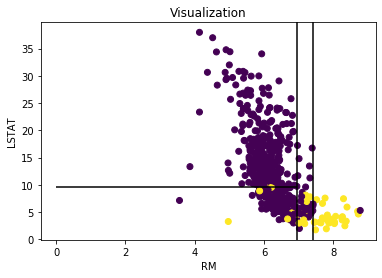

In [163]:
# Visualize your splits on an X-Y plane.
plt.scatter(boston_df['RM'], boston_df['LSTAT'], c=boston_df['highPriced'])
plt.title('Visualization')
# RM on X axis
plt.xlabel('RM')
# LSTAT on Y axis
plt.ylabel('LSTAT')
# Vertical line representing first split i.e RM = 6.94
plt.axvline(x = 6.94,color='black')
# Horizontal line representing second split i.e LSTAT = 9.53
plt.hlines(y = 9.53, xmin=0, xmax=6.94,color='black')
# Vertical line representing second split i.e RM = 7.42
plt.axvline(x = 7.42,color='black')
plt.show()


In [164]:
# Values in purple represent False and Yellow represwnt True
# the lines are drwn based on the split values of RM and LSTAT

### Part 3: Making predictions

In [165]:
#splitting every 5th row into testing set
training_df = boston_df[boston_df.index % 5 != 0]  
testing_df = boston_df[boston_df.index % 5 == 0]  

In [166]:
training_df.describe()
# There are 404 Training observations 
training_df['highPriced'].describe()
# the training set target values have majority of False values , i.e 363 out of 404

count       404
unique        2
top       False
freq        363
Name: highPriced, dtype: object

In [167]:
testing_df.describe()
# there are 102 testing observations
testing_df['highPriced'].describe()
# the testing set target values have majority of False values , i.e 95 out of 102
# the distribution of the target variable looks simialr in both training and testing set

count       102
unique        2
top       False
freq         95
Name: highPriced, dtype: object

In [168]:
# Random sampling by replacement from the entire Trainig set to predict values for Test set
RandomPredictedValues = training_df['highPriced'].sample(n=len(testing_df), replace=True).tolist()
# Accuracy of the prediction based on sampling varies in the range 80 - 95 % for each execution
accuracy1 = accuracy_score(testing_df.get('highPriced'), RandomPredictedValues)
print(accuracy1)

0.8921568627450981


In [169]:
# To evaluate classification based on precision and recall  
print(classification_report(testing_df.get('highPriced'), RandomPredictedValues))

              precision    recall  f1-score   support

       False       0.93      0.96      0.94        95
        True       0.00      0.00      0.00         7

    accuracy                           0.89       102
   macro avg       0.46      0.48      0.47       102
weighted avg       0.86      0.89      0.88       102



In [170]:
# functiont to calculate probablity of each class in the node 
def leaf_node_probablity(dataset, column_name):
    prob = []
    class_values = dataset[column_name].unique()
    for val in class_values:
        prob.append(len(dataset[dataset[column_name]==val])/len(dataset))
    return prob

In [171]:
# function to predict values based on the Tree built from Training set
def predict_values(column_names, train, test, max_depth):
    tree = build_tree(column_names, train, max_depth+1)
    predictions = list()
    probablities = []
    for i,row in test.iterrows():
        prediction, node_probablity = get_prediction(tree, row)
        predictions.append(prediction)
        probablities.append(node_probablity)
    return predictions, probablities

In [172]:
# function used to traverse through the Tree to reach leaf node
# On reaching leaf node, sandom samples are selected from the leaf node values
def get_prediction(tree, row):
    while tree is not None and tree.get('cutoff'): 
        column_name = tree['column_name']
        value = row[column_name]
        random_row = tree['Dataset']['highPriced'].sample().tolist()
        node_probablity = leaf_node_probablity(tree['Dataset'],'highPriced')
        if entropy != 0:
            if value < tree['cutoff']:   # get the direction 
                tree = tree['left']
            else:
                tree = tree['right']
    return random_row[0], node_probablity

In [173]:
# using a 2-level decision tree to make predictions with only the RM and LSTAT variables
column_list = []
level_list = []
threshold_list = []
node_probablities = []

predictions, node_probablities = predict_values(['RM','LSTAT'],training_df, testing_df, 1)

# Updating values of level
level_list = [abs(x-1)+1 for x in level_list]
level_list

# Tree information: Level, Column Name and Threshold of split
tree_df = pd.DataFrame({'level':level_list, 'Column Name': column_list, 'Threshold': threshold_list})
tree_df

C:\Users\sahan\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: RuntimeWarning: divide by zero encountered in log2
  after removing the cwd from sys.path.
C:\Users\sahan\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in double_scalars
  after removing the cwd from sys.path.


,level,Column Name,Threshold
0,2,RM,7.147
1,1,LSTAT,9.530
2,1,RM,7.420


In [174]:
# probablities from leaf nodes
np.unique(node_probablities, axis=0)

array([[0.31111111, 0.68888889],
       [0.97486034, 0.02513966]])

In [175]:
accuracy2 = accuracy_score(testing_df.get('highPriced'), predictions)
accuracy2

0.9117647058823529

In [176]:
# To evaluate classification based on precision and recall  
print(classification_report(testing_df.get('highPriced'), predictions))

              precision    recall  f1-score   support

       False       0.96      0.95      0.95        95
        True       0.38      0.43      0.40         7

    accuracy                           0.91       102
   macro avg       0.67      0.69      0.68       102
weighted avg       0.92      0.91      0.91       102



In [177]:
# The prediction using the decision tree has higher accuracy than the Random prediction from the entirety of the dataset

### Part 4: Comparing to out-of-the-box classiers

In [178]:
#Using sklearn's DecisionTreeClassier
feature_cols = ['RM', 'LSTAT' ]
X_train = training_df[feature_cols]
X_test = testing_df[feature_cols]

# target/ class labels
y_train = training_df['highPriced']
y_test = testing_df['highPriced']

target_names = [True, False]

# Creating Decision Tree classifer model with max depth 2 
decision_tree_2 = tree.DecisionTreeClassifier(criterion = 'entropy', max_depth=2)
clf = decision_tree_2.fit(X_train,y_train)
y_pred = clf.predict(X_test)
r = export_text(clf, feature_names=feature_cols)
print(r)

|--- RM <= 7.13
|   |--- LSTAT <= 5.12
|   |   |--- class: False
|   |--- LSTAT >  5.12
|   |   |--- class: False
|--- RM >  7.13
|   |--- RM <= 7.44
|   |   |--- class: False
|   |--- RM >  7.44
|   |   |--- class: True



In [179]:
# Calculating accuracy of DecisionTreeClassier
accuracy3 = accuracy_score(testing_df.get('highPriced'), y_pred)
accuracy3

0.9705882352941176

In [180]:
# probablities at leaf node of the decision tree
np.unique(decision_tree_2.predict_proba(X_test),axis=0)

array([[0.03846154, 0.96153846],
       [0.65      , 0.35      ],
       [0.77777778, 0.22222222],
       [0.99093656, 0.00906344]])

In [181]:
# To evaluate classification based on precision and recall  
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

       False       0.97      1.00      0.98        95
        True       1.00      0.57      0.73         7

    accuracy                           0.97       102
   macro avg       0.98      0.79      0.86       102
weighted avg       0.97      0.97      0.97       102



In [182]:
# The probablities obtained for the leaf nodes are very close to the probablities from the decision tree in 12th question
# The split values or cutOff for each node are also similarly very close

In [183]:
# Using sklearn's BaggingClassier
from sklearn import model_selection 
from sklearn.ensemble import BaggingClassifier 

In [184]:
seed = 8
kfold = model_selection.KFold(n_splits = 3, random_state = seed) 
  
# DecisionTreeClassifier as the base classifier 
base_cls = DecisionTreeClassifier() 
  
# no. of base classifier 
num_trees = 500
  
# bagging classifier 
BaggingClassifiermodel = BaggingClassifier(base_estimator = base_cls, 
                          n_estimators = num_trees, 
                          random_state = seed) 
  
results = model_selection.cross_val_score(BaggingClassifiermodel, X_train, y_train, cv = kfold) 
print("accuracy of BaggingClassifier :") 
print(results.mean()) 


accuracy of BaggingClassifier :
0.9233646581905287


In [185]:
# the accuracy of the BaggingClassifier is lesser than the DecisionTreeClassier

In [186]:
from sklearn.ensemble import RandomForestClassifier

#Create a Random Forest Classifier
RandomForestClassifierModel=RandomForestClassifier(n_estimators=100)

#Train the model 
Rclf = RandomForestClassifierModel.fit(X_train,y_train)
# Making predictions
Predictions=Rclf.predict(X_test)
# Calculating accuracy of DecisionTreeClassier
Model_accuracy = accuracy_score(y_test, Predictions)
Model_accuracy

0.9607843137254902

In [187]:
# the accuracy of the RandomForestClassifier is definitely higher then the both BaggingClassifier and DecisionTreeClassier

In [188]:
# To evaluate classification based on precision and recall  
print(classification_report(y_test, Predictions))

              precision    recall  f1-score   support

       False       0.98      0.98      0.98        95
        True       0.71      0.71      0.71         7

    accuracy                           0.96       102
   macro avg       0.85      0.85      0.85       102
weighted avg       0.96      0.96      0.96       102

